In [1]:
# configuration
shuffle = False

file_path = "Z:/BA/mimii_baseline/dataset"
pickle_dir = 'D:\9999_OneDrive_ZHAW\OneDrive - ZHAW\BA_ZHAW_RTO\pickle'



# imports
import os
import random
import pickle
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Load .wav with librosa

In [52]:
# load audio file
filename = 'data/mimii/00000061_6_6_ab.wav'
y, sr = librosa.load(filename, mono=False, sr=None)

# calculate the Short-Time Fourier Transform (STFT)
hop_length = 512
n_fft = 1024
S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

# Calculate frequency range
freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
freq_min = freqs[0] / 1000.0
freq_max = freqs[-1] / 1000.0
print(f'samling rate: {sr}')
print("Frequency range: {:.2f} kHz - {:.2f} kHz".format(freq_min, freq_max))

print(S)

# calculate the logarithmic average of the amplitude spectra across time
log_S = librosa.amplitude_to_db(S, ref=np.max)
mean_log_S = np.mean(log_S, axis=1)

# convert to dB
mean_dB_S = librosa.core.power_to_db(mean_log_S**2)
mean_dB_S = mean_dB_S.astype(np.float64)

print(mean_dB_S)
print(np.shape(mean_dB_S))

samling rate: 16000
Frequency range: 0.00 kHz - 8.00 kHz
[[[0.11074685 0.02197825 0.10735482 ... 0.07764798 0.00600009 0.01687738]
  [0.11814624 0.04679294 0.16072537 ... 0.16097565 0.18583758 0.10681573]
  [0.13605584 0.22723131 0.16025838 ... 0.5691015  0.17659609 0.1450074 ]
  ...
  [0.04340516 0.04157101 0.00647917 ... 0.11372207 0.08697798 0.03224215]
  [0.0274035  0.02454872 0.05032782 ... 0.08718708 0.04547874 0.02403091]
  [0.00250714 0.03820272 0.03481561 ... 0.04057902 0.00137326 0.0469485 ]]

 [[0.0851843  0.05135053 0.04576935 ... 0.05602184 0.05701458 0.05848645]
  [0.089649   0.05065881 0.05804113 ... 0.14671022 0.13183288 0.04577818]
  [0.11076193 0.23501875 0.32179293 ... 0.5724624  0.3364418  0.17624843]
  ...
  [0.04759858 0.02382757 0.00865377 ... 0.03488499 0.01444836 0.02593054]
  [0.03633274 0.0444347  0.08471091 ... 0.0855777  0.0375507  0.05613076]
  [0.02338651 0.02453338 0.07849063 ... 0.11409756 0.01286163 0.08981325]]

 [[0.07933355 0.04498765 0.05325922 ...

## Create spectrogram of loaded .wav

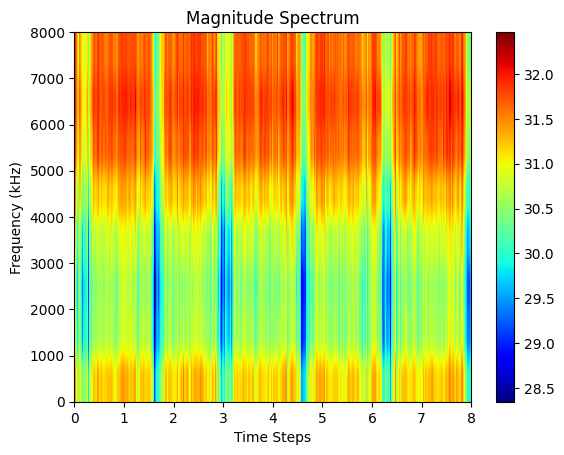

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
heatmap = ax.imshow(mean_dB_S, cmap='jet', aspect='auto', origin='lower',
                    extent=[0, mean_dB_S.shape[0], 0, sr/2])
                    # extend sets the bounding box for the plot, that means that 
                    # the x axis goes from 0 to the nr. of rows (time)
                    # and the y axis from freq_min to freq_max

# Add a colorbar
cbar = fig.colorbar(heatmap)

# Add axis labels and title
ax.set_xlabel('Time Steps')
ax.set_ylabel('Frequency (kHz)')
ax.set_title('Magnitude Spectrum')

# Display the plot
plt.show()

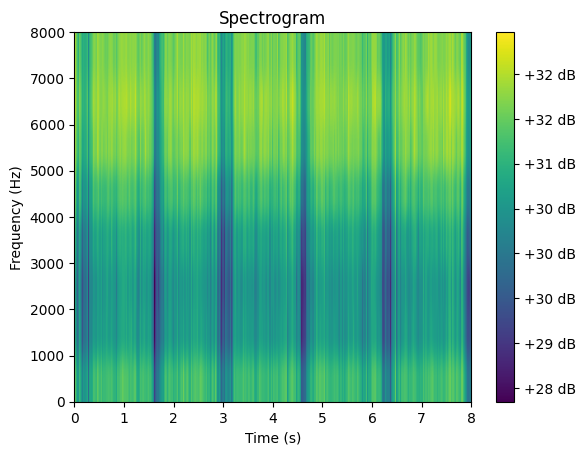

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Create heatmap
heatmap = ax.imshow(mean_dB_S, cmap='viridis', aspect='auto', origin='lower',
                    extent=[0, mean_dB_S.shape[0], 0, sr/2])

# Add a colorbar
cbar = fig.colorbar(heatmap, ax=ax, format='%+2.0f dB')

# Add axis labels and title
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('Spectrogram')

# Display the plot
plt.show()


# Load data, norm, pca (mel_spectrogram!)

Load normal and abnormal files  
Normalize them  
Create first pca

The data is loaded as a mel_spectrogram which models the human auditory system better. This could be changed if necessary since our collected data is right know directly from the fft into dB. (the bins in mel are non linear distributed, unlike to the regular spectrogram)

It should be possible to transform a regular spectrogram into mel before scaling it to dB, if directly converted after collecting fft data.

In [2]:

def file_names(root_dir, normal_dir = "normal", abnormal_dir = "abnormal"):
    normal_files = []
    abnormal_files = []
    
    # recusrivly traversing through the root_dir
    for root, dirs, files in os.walk(root_dir):
        for name in files:
            current_dir_type = os.path.split(root)[-1] # normal or abnormal
            if current_dir_type == normal_dir:
                normal_files.append(os.path.join(root, name))
            if current_dir_type == abnormal_dir:
                abnormal_files.append(os.path.join(root, name))

    return normal_files, abnormal_files


def dataloader(files_list, n_fft=1024, hop_length=512, n_mels=64, frames=5):
    dims = n_mels * frames
    
    for idx in tqdm(range(len(files_list)), desc='Dataloader: '):
        signal, sr = file_load(files_list[idx])
        features = extract_features(
        signal,
        sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        frames=frames,
        )
        
        if idx == 0:
            dataset = np.zeros((features.shape[0] * len(files_list), dims), np.float32)
        
        dataset[
            features.shape[0] * idx : features.shape[0] * (idx + 1), :
        ] = features
        
    return dataset
        

def file_load(wav_name, mono=False, channel=0):
    signal, sr = librosa.load(wav_name, mono=False, sr=None)
    if signal.ndim <= 1:
        sound_file = signal, sr
    else:
        sound_file = signal[channel, :], sr

    return sound_file
    
def extract_features(signal, sr, n_fft=1024, hop_length=512, 
                     n_mels=64, frames=5):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    features_vector_size = log_mel_spectrogram.shape[1] - frames + 1
    
    dims = frames * n_mels

    if features_vector_size < 1:
        return np.empty((0, dims), np.float32)

    features = np.zeros((features_vector_size, dims), np.float32)
    for time in range(frames):
        features[:, n_mels * time : n_mels * (time + 1)] = log_mel_spectrogram[
            :, time : time + features_vector_size
        ].T

    return features
    

## Data loading and feature labelling

In [6]:
# takes about 12-14 minutes
n_fft = 2048
hop_length = 512
n_mels = 64
frames = 5

dim_1 = 313 - frames + 1
dim_2 = n_mels * frames

# Load file loacations
normal_files, abnormal_files = file_names(file_path)

# Feature labelling
normal_labels = np.zeros(len(normal_files))
abnormal_labels = np.ones(len(abnormal_files))


normal_data = dataloader(
    normal_files, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, frames=frames)
abnormal_data = dataloader(
    abnormal_files, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, frames=frames)


NameError: name 'file_names' is not defined

In [4]:
n_fft = 2048
hop_length = 512
n_mels = 64
frames = 5

print(np.shape(normal_data))
print(np.shape(normal_labels))

NameError: name 'normal_data' is not defined

## Save loaded data to pickle

In [3]:
# pickle I/O
def save_pickle(filename, save_data):
    """
    picklenize the data.

    filename : str
        pickle filename
    data : free datatype
        some data will be picklenized

    return : None
    """
    with open(filename, 'wb') as sf:
        pickle.dump(save_data, sf)


def load_pickle(filename):
    """
    unpicklenize the data.

    filename : str
        pickle filename

    return : data
    """
    with open(filename, 'rb') as lf:
        load_data = pickle.load(lf)
    return load_data

### save

In [20]:
save_pickle(os.path.join(pickle_dir, 'normal_files' + '.pickle'), normal_files)
save_pickle(os.path.join(pickle_dir, 'abnormal_files' + '.pickle'), abnormal_files)

save_pickle(os.path.join(pickle_dir, 'normal_data' + '.pickle'), normal_data)
save_pickle(os.path.join(pickle_dir, 'abnormal_data' + '.pickle'), abnormal_data)

save_pickle(os.path.join(pickle_dir, 'normal_labels' + '.pickle'), normal_labels)
save_pickle(os.path.join(pickle_dir, 'abnormal_labels' + '.pickle'), abnormal_labels)
print('saved successfully')

saved successfully


### load

In [6]:
normal_files = load_pickle(os.path.join(pickle_dir, 'normal_files' + '.pickle'))
abnormal_files = load_pickle(os.path.join(pickle_dir, 'abnormal_files' + '.pickle'))

normal_data = load_pickle(os.path.join(pickle_dir, 'normal_data' + '.pickle'))
abnormal_data = load_pickle(os.path.join(pickle_dir, 'abnormal_data' + '.pickle'))

normal_labels = load_pickle(os.path.join(pickle_dir, 'normal_labels' + '.pickle'))
abnormal_labels = load_pickle(os.path.join(pickle_dir, 'abnormal_labels' + '.pickle'))
print('loaded successfully')

loaded successfully


### !Testing loading data (old)

In [14]:
target_dir = "Z:/BA/mimii_baseline/dataset/0dB/pump/id_02/normal"
file_names = os.listdir(target_dir)

dfs = []

# calculate the Short-Time Fourier Transform (STFT)
hop_length = 512
n_fft = 1024

for file in tqdm(os.listdir(target_dir), desc = "loading data:"):
    file_path = os.path.join(target_dir, file)
    y, sr = librosa.load(file_path, mono=False, sr=None)    
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    
    # calculate the logarithmic average of the amplitude spectra across time
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    mean_log_S = np.mean(log_S, axis=1)

    # convert to dB
    mean_dB_S = librosa.core.power_to_db(mean_log_S**2)
    mean_dB_S = mean_dB_S.astype(np.float64)

    dfs.append(mean_dB_S)  # append all the dataframes to a list of dfs

merged_df = np.concatenate(dfs, axis = 0)
print(merged_df)
print(np.shape(merged_df))

loading data:: 100%|███████████████████████████████████████████████████████████████| 1005/1005 [02:06<00:00,  7.92it/s]

[[32.26648712 31.45277023 31.29323006 ... 31.23600388 30.97746658
  31.1955719 ]
 [32.07359695 31.32201958 30.98748398 ... 30.94579315 30.67772293
  30.81822968]
 [32.5767746  31.36368752 30.93621254 ... 31.17440987 30.6873703
  30.85907173]
 ...
 [33.31126785 32.7675705  32.84405136 ... 33.13071823 32.90040207
  32.52823639]
 [33.55658722 33.03084564 33.12168121 ... 33.19655609 33.17086029
  33.03913498]
 [33.48710251 32.86865616 33.04972839 ... 33.08201981 33.1413002
  32.86829376]]
(8040, 313)


## Reshape and shuffle

In [7]:
dim_1 = 313 - frames + 1
dim_2 = n_mels * frames

data = np.concatenate([normal_data, abnormal_data], axis=0)
data_label = np.concatenate([normal_labels, abnormal_labels], axis=0)

# reshape
normal_data_resh = normal_data.reshape(int(normal_data.shape[0]/dim_1),dim_1,dim_2)
abnormal_data_resh = abnormal_data.reshape(int(abnormal_data.shape[0]/dim_1),dim_1,dim_2)

data_resh = np.concatenate([normal_data_resh,abnormal_data_resh], axis =0)

In [14]:
# save data
save_pickle(os.path.join(pickle_dir, 'normal_data_resh' + '.pickle'), normal_data_resh)
save_pickle(os.path.join(pickle_dir, 'abnormal_data_resh' + '.pickle'), abnormal_data_resh)
save_pickle(os.path.join(pickle_dir, 'data' + '.pickle'), data)
save_pickle(os.path.join(pickle_dir, 'data_resh' + '.pickle'), data_resh)
print('saved successfully')

saved successfully


In [8]:
# dataframe to collect all results
results = pd.DataFrame({'label' : data_label})

# Create splits
normal_idx = np.arange(len(normal_files))  # create an array of indices of normal files
abnormal_idx = np.arange(len(abnormal_files)) + normal_idx.shape[0]  # create an array of indices of abnormal files

# Index all samples
all_idx = np.hstack([normal_idx, abnormal_idx])  # concatenate the indices of normal and abnormal files
results['idx'] = all_idx  # store the concatenated indices in the 'ind' key of the 'results' dictionary

# Number of samples
N = all_idx.shape[0]  # get the total number of samples

# shuffle to shuffle file structure
normal_idx_shuffle = normal_idx.copy()  # create a copy of the normal indices
abnormal_idx_shuffle = abnormal_idx.copy()  # create a copy of the abnormal indices
if shuffle:
    np.random.shuffle(normal_idx_shuffle)  # shuffle the normal indices if the shuffle flag is True
    np.random.shuffle(abnormal_idx_shuffle)  # shuffle the abnormal indices if the shuffle flag is True

# insert abnormal in middle
cut_idx = int(np.floor(normal_idx.shape[0]/2))  # get the index to split the normal indices in half
normal_idx_a = normal_idx_shuffle[:cut_idx]  # get the first half of shuffled normal indices
normal_idx_b = normal_idx_shuffle[cut_idx:]  # get the second half of shuffled normal indices
abnormal_toadd = abnormal_idx_shuffle.copy()  # create a copy of shuffled abnormal indices

# insert 
all_idx_shuffle = np.hstack([normal_idx_a,abnormal_toadd,normal_idx_b])  # concatenate the first half of shuffled normal indices, shuffled abnormal indices, and the second half of shuffled normal indices
results['idx_shuffle'] = all_idx_shuffle  # store the concatenated indices in the 'ind_shuffle' key of the 'results' dictionary

ratio = len(abnormal_idx) / len(all_idx)  # calculate the ratio of abnormal samples to total samples
ratio

0.1084423305588585

In [15]:
# save data
save_pickle(os.path.join(pickle_dir, 'results' + '.pickle'), results)
save_pickle(os.path.join(pickle_dir, 'normal_idx' + '.pickle'), normal_idx)
save_pickle(os.path.join(pickle_dir, 'abnormal_idx' + '.pickle'), abnormal_idx)
save_pickle(os.path.join(pickle_dir, 'all_idx' + '.pickle'), all_idx)
print('saved successfully')

saved successfully


In [7]:
# load data
data = load_pickle(os.path.join(pickle_dir, 'data' + '.pickle'))
data_resh = load_pickle(os.path.join(pickle_dir, 'data_resh' + '.pickle'))

results = load_pickle(os.path.join(pickle_dir, 'results' + '.pickle'))
normal_idx = load_pickle(os.path.join(pickle_dir, 'normal_idx' + '.pickle'))
abnormal_idx = load_pickle(os.path.join(pickle_dir, 'abnormal_idx' + '.pickle'))
all_idx = load_pickle(os.path.join(pickle_dir, 'all_idx' + '.pickle'))
print('loaded successfully')

loaded successfully


### Smaller sample of data

In [8]:
# load data
normal_data_resh = load_pickle(os.path.join(pickle_dir, 'normal_data_resh' + '.pickle'))
abnormal_data_resh = load_pickle(os.path.join(pickle_dir, 'abnormal_data_resh' + '.pickle'))

In [443]:
print('normal_resh:', np.shape(normal_data_resh))
print('abnormal_resh:', np.shape(abnormal_data_resh))

max_norm = 1200
max_abnorm = int(0.2*max_norm)

normal_data_small = normal_data[:max_norm]
abnormal_data_small = abnormal_data[:max_abnorm]

normal_data_resh_small = normal_data_resh[:max_norm]
abnormal_data_resh_small = abnormal_data_resh[:max_abnorm]

normal_labels_small = normal_labels[:max_norm]
abnormal_labels_small = abnormal_labels[:max_abnorm]

print('normal_resh_small:', np.shape(normal_data_resh_small))
print('abnormal_resh_small:', np.shape(abnormal_data_resh_small), '\n')
print('shape normal_data_resh_small:', np.shape(normal_data_resh_small))
print('shape normal_data_small:', np.shape(normal_data_small))

normal_resh: (11247, 309, 320)
abnormal_resh: (1368, 309, 320)
normal_resh_small: (1200, 309, 320)
abnormal_resh_small: (240, 309, 320) 

shape normal_data_resh_small: (1200, 309, 320)
shape normal_data_small: (1200, 320)


# Visualization of sample inputs
It is possible that healthy and faulty are not correct in the plots (maybe they are mixed, looks like)

1059 4384 2110
1063 605 1184


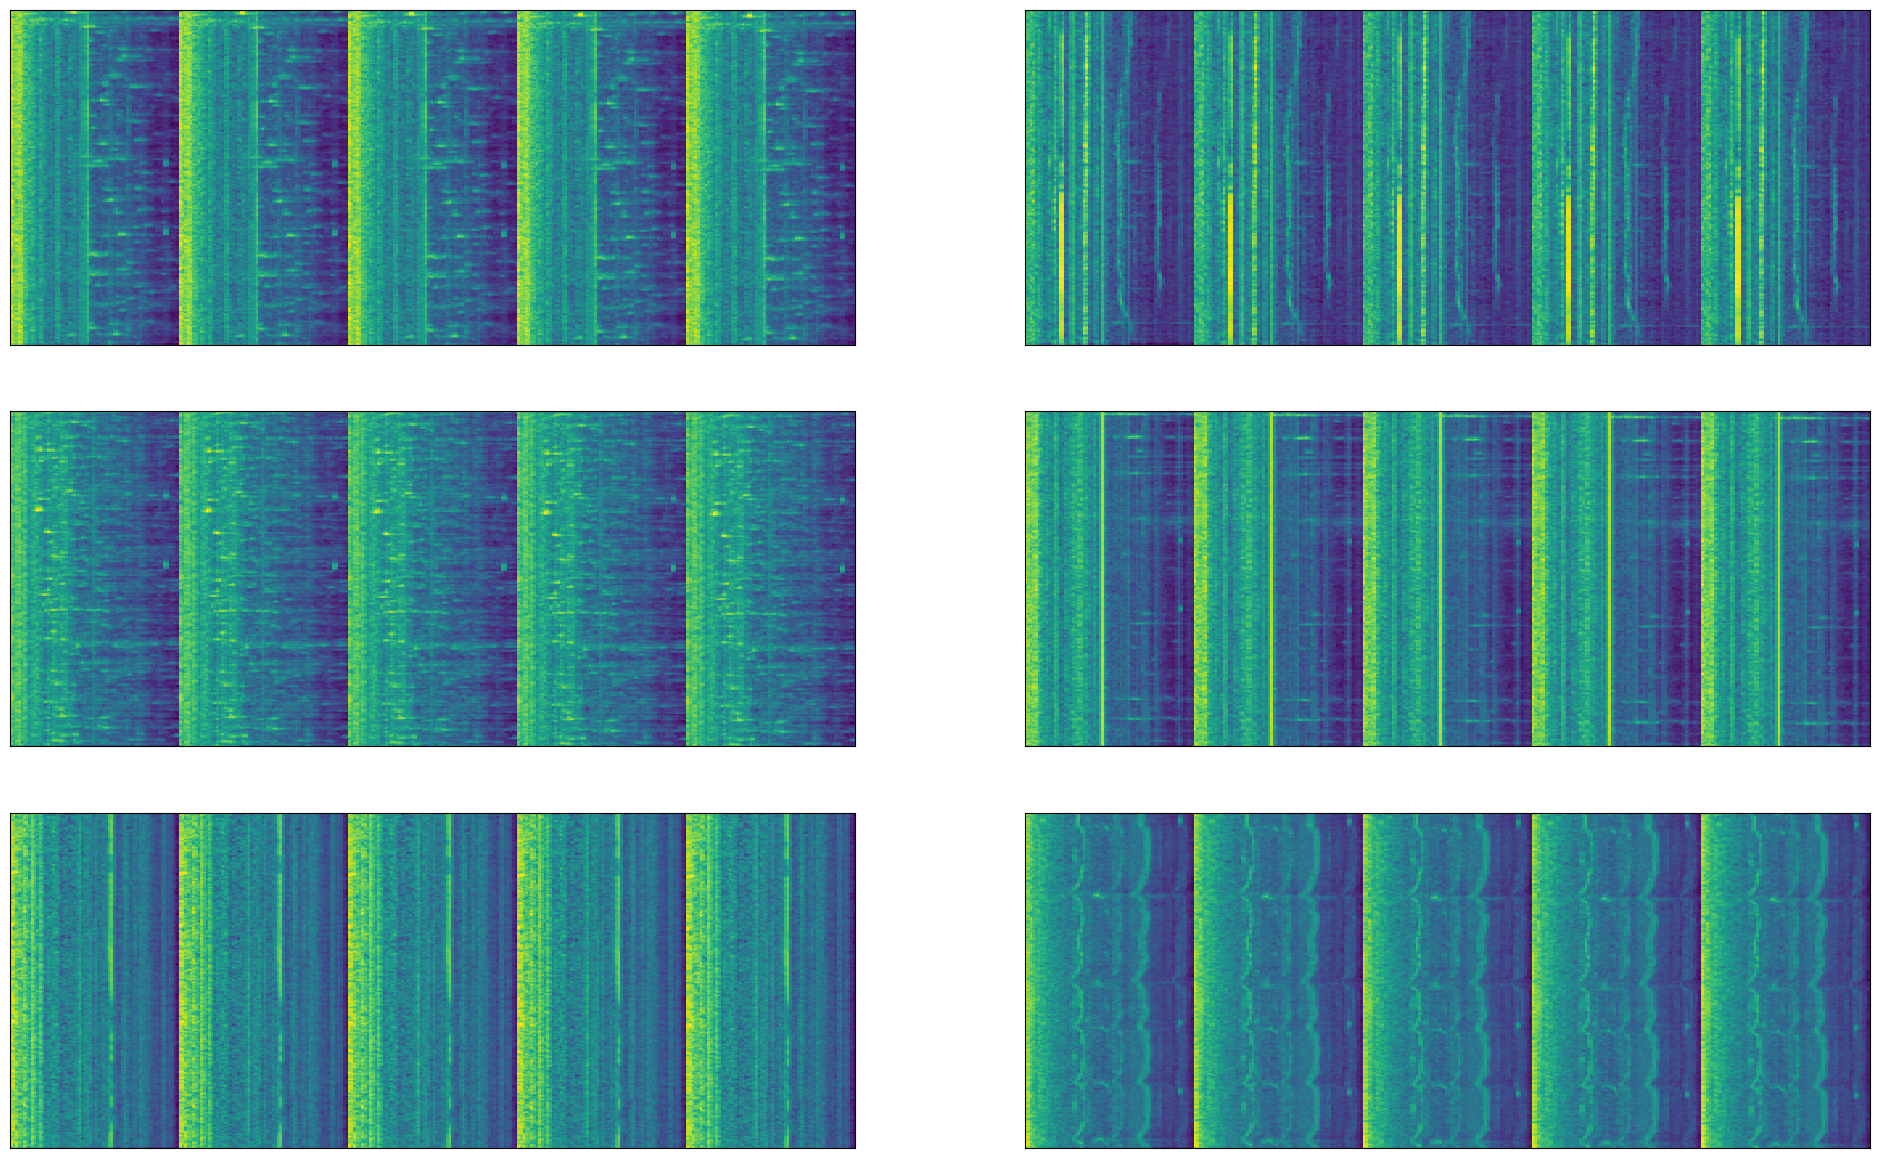

In [13]:
# look at samples which are fed to neural network
# Watch out the neural network only get 1 D inputs (rows)
# show healthy and faulty example

# load one file to get sampling rate
_, sr = file_load(abnormal_files[40])

norm1,norm2,norm3 = random.sample(range(0,normal_idx.shape[0]),3)
abnorm1,abnorm2,abnorm3 = random.sample(range(0,abnormal_idx.shape[0]),3)
print(norm1, norm2, norm3)
print(abnorm1, abnorm2, abnorm3)

fig = plt.figure(figsize=(24, 20))

# Real Signal
plt.subplot(4, 2, 1)
t = 0
librosa.display.specshow(
    data_resh[normal_idx[norm1],:,:],
    sr=sr,
    hop_length=hop_length,
    cmap="viridis",
)
plt.subplot(4, 2, 3)
t = 0
librosa.display.specshow(
    data_resh[normal_idx[norm2],:,:],
    sr=sr,
    hop_length=hop_length,
    cmap="viridis",
)
plt.subplot(4, 2, 5)
t = 0
librosa.display.specshow(
    data_resh[normal_idx[norm3],:,:],
    sr=sr,
    hop_length=hop_length,
    cmap="viridis",
)


# Reconstruction
plt.subplot(4, 2, 2)
t = 0
librosa.display.specshow(
    data_resh[abnormal_idx[abnorm1],:,:],
    sr=sr,
    hop_length=hop_length,
    cmap="viridis",
)
plt.subplot(4, 2, 4)
t = 0
librosa.display.specshow(
    data_resh[abnormal_idx[abnorm2],:,:],
    sr=sr,
    hop_length=hop_length,
    cmap="viridis",
)
plt.subplot(4, 2, 6)
t = 0
librosa.display.specshow(
    data_resh[abnormal_idx[abnorm3],:,:],
    sr=sr,
    hop_length=hop_length,
    cmap="viridis",
)


In [5]:
import os

filepath = 'data/pump_id'
def filefinder(root):
    files = []
    for file in os.listdir(root):
        files.append(os.path.join(root, file))
    return files

filelist = filefinder(filepath)
filelist







['data/pump_id\\0dB.wav', 'data/pump_id\\6dB.wav', 'data/pump_id\\min6dB.wav']

## Normalize data

In [74]:
def normalize_data(x, lb, ub, max_v=1.0, min_v=-1.0):
    '''
    Max-Min normalize of 'x' with max value 'max_v' min value 'min_v'
    '''

    # Set-up
    if len(ub)==0:
        ub = x.max(0) # OPTION 1
        # applied to the first dimension (0) columns of the data
        #ub = np.percentile(x, 99.9, axis=0, keepdims=True) # OPTION 2:
        
    if len(lb)==0:
        lb = x.min(0) 
        #lb = np.percentile(x, 0.1, axis=0, keepdims=True)
    
    ub.shape = (1,-1)
    lb.shape = (1,-1)           
    max_min = max_v - min_v
    delta = ub-lb

    # Compute
    x_n = max_min * (x - lb) / delta + min_v
    if 0 in delta:
        idx = np.ravel(delta == 0)
        x_n[:,idx] = x[:,idx] - lb[:, idx]

    return x_n, lb, ub 

In [75]:
def batch_normalize_data(x_data, batch_size, lb=[], ub=[], max_v=1.0, min_v=-1.0):
    """
    Normalize a list of data in batches.
    :param x_list: List of numpy arrays.
    :param batch_size: Batch size to use.
    :param lb: Lower bound for normalization. If empty, calculated from data.
    :param ub: Upper bound for normalization. If empty, calculated from data.
    :param max_v: Max value for normalization.
    :param min_v: Min value for normalization.
    :return: List of normalized numpy arrays.
    """
    normalized_data = []

    for i in tqdm(range(0, len(x_data), batch_size), desc='normalazing:'):
        batch_x = x_data[i:i+batch_size]
        normalized_batch_x, lb, ub = normalize_data(np.vstack(batch_x), [], [], max_v=1.0, min_v=0.0)
        normalized_data.append(normalized_batch_x)

    return np.vstack(normalized_data)


In [273]:
# NOTE: Nomalization for anomaly detection is typically done with the labeled dataset and not 
# with the full development dataset
# Sensor readings
data_n, lb, ub = normalize_data(normal_data_small, [], [], max_v=1.0, min_v=0.0)
# data_n = batch_normalize_data(normal_data_resh_small, batch_size=32)


print('')
print ("number of examples in the development subset = " + str(data_n.shape[0]))
print ("data_n shape: " + str(data_n.shape))

#print(data)
print(data_n[:5])


number of examples in the development subset = 2000
data_n shape: (2000, 320)
[[0.511892   0.46838307 0.5409465  ... 0.3121249  0.27145562 0.2634068 ]
 [0.7734653  0.7498318  0.7010742  ... 0.38184327 0.3346295  0.42657247]
 [0.81396914 0.78259647 0.67217153 ... 0.36780524 0.31281117 0.36009112]
 [0.8118113  0.69126016 0.6517527  ... 0.3400709  0.34042645 0.30325207]
 [0.7769718  0.70907503 0.67480505 ... 0.56365955 0.50173044 0.37893403]]


In [ ]:
# save data
save_pickle(os.path.join(pickle_dir, 'data_n' + '.pickle'), data_n)
print('successfully saved')

In [4]:
# load data
data_n = load_pickle(os.path.join(pickle_dir, 'data_n' + '.pickle'))
print('successfully loaded')
print(data_n[:5])

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\9999_OneDrive_ZHAW\\OneDrive - ZHAW\\BA_ZHAW_RTO\\pickle\\data_n.pickle'

## PCA

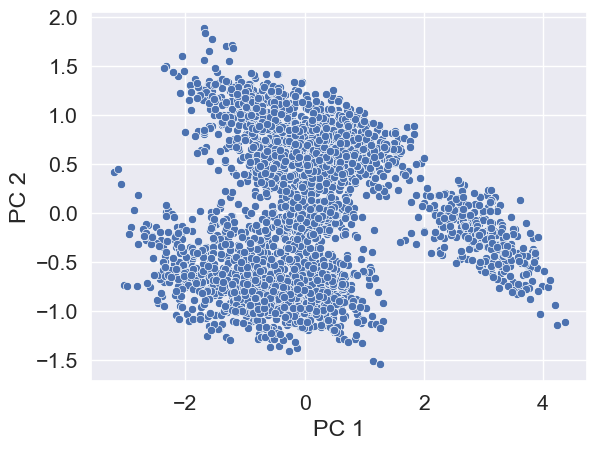

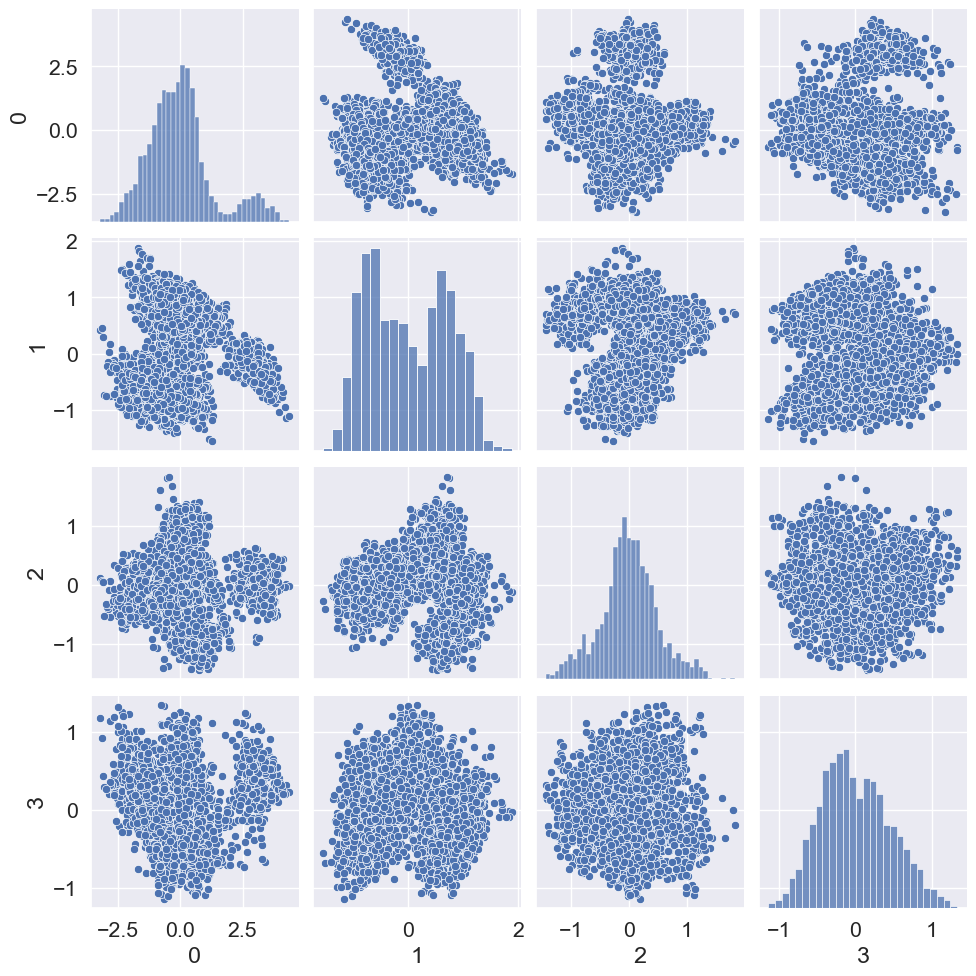

In [254]:
# apply PCA

# substract the mean
X = data_n - data_n.mean(axis = 0)

# pca with x dim
pca = PCA(n_components = 4)

# project the data on the new dimension
projected = pca.fit_transform(X)

df_projected = pd.DataFrame(projected[:, :2], columns=['PC 1', 'PC 2'])

#plot - what can you observe from the plot?
# plt.scatter(projected[:, 0], projected[:, 1], c=labels , edgecolor='none', alpha=0.5)
sns.scatterplot(data=df_projected, x='PC 1', y='PC 2')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# plt.colorbar()
plt.show()

df_projected_2 = pd.DataFrame(projected)
sns.pairplot(df_projected_2)

# AE approach

In [78]:
import os
import h5py
import time
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas import DataFrame
from itertools import product
from matplotlib import gridspec
from operator import itemgetter
from time import gmtime, strftime
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [416]:
# Validation as subset of development data
indices = np.arange(data_n.shape[0])

idx_train, idx_val = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

data_n_val = data_n[np.sort(idx_val)]
data_n_train = data_n[np.sort(idx_train)]

# create test dataset with normal and abnormal data
start_1 = 0
start_2 = 0

max_norm_sample = 800
max_abnorm_sample = 400

norm_sample = normal_data[start_1:(start_1+max_norm_sample)]
abnorm_sample = abnormal_data[start_2:(start_2+max_abnorm_sample)]

# norm_sample_indices = np.random.choice(range(normal_data.shape[0]), size=max_norm_sample, replace=False)
# norm_sample = normal_data[norm_sample_indices]
# abnorm_sample_indices = np.random.choice(range(abnormal_data.shape[0]), size=max_abnorm_sample, replace=False)
# abnorm_sample = abnormal_data[abnorm_sample_indices]


normal_test , _, _ =  normalize_data(norm_sample, [], [], max_v=1.0, min_v=0.0)
abnormal_test, _, _ = normalize_data(abnorm_sample, [], [], max_v=1.0, min_v=0.0)
data_n_test = np.concatenate([normal_test, abnormal_test], axis = 0)
np.shape(data_n_test)

(1200, 320)

In [417]:
def create_encoder(input_shape, config):
    """
    Creates an encoder network with an architecture
    following a geometric series where each hidden layer 
    has half the number of neurons as the previous layer
    inputs:
        input_shape: tuple with input shape
        config: dictionary with nn configuration
    outputs:
        z: np.array with lantent space
        encoder: tf model        
    """ 
    
    # Architecture
    latent_dim = config['n_ls_a']  # latent space dim
    cells = [int(config['n_cl_a']*(0.5)**i) for i in range(config['n_hl_a'])]
    
    
    # Define the inputs, input layer
    X_inputs = tf.keras.Input(shape=input_shape, name='encoder_input') 
    X = X_inputs
    
    # Encoding, going through the hidden layers (cells defined above)
    for i in range(config['n_hl_a']):
        X = tf.keras.layers.Dense(cells[i],
                                  activation=config['activ'],
                                  kernel_initializer=tf.keras.initializers.glorot_uniform(seed=config['seed']))(X)
        
    # Latent vector
    z = tf.keras.layers.Dense(latent_dim, name='z')(X)  
    
    # Build encoder from 'X_inputs' to 'z' space
    encoder = tf.keras.Model(X_inputs, z, name='encoder')
    
    return z, encoder

def create_decoder(output_shape, config):
    """
    inputs:
        input_shape: tuple with input shape
        config: dictionary with nn configuration
    outputs:
        outputs: np.array with reconstruction signal
        decoder: tf model        
    """
    
    # Architecture
    latent_dim = config['n_ls_a']
    cells = [int(config['n_cl_a']*(0.5)**i) for i in range(config['n_hl_a'])]
    
    # Define the inputs (from vector to time-dependent input)
    Z_inputs = tf.keras.Input(shape=(latent_dim,))
    X = Z_inputs
    
    # Dencoding      
    for i in reversed(range(config['n_hl_a'])):
        X = tf.keras.layers.Dense(cells[i],                                       
                                  activation=config['activ'],
                                  kernel_initializer=tf.keras.initializers.glorot_uniform(seed=config['seed']))(X)

    # Reconstructed input
    outputs = tf.keras.layers.Dense(output_shape[-1])(X)
    
    # Build decoder model
    decoder = tf.keras.Model(Z_inputs, outputs, name='decoder')
    # rebuilds the input to the output
    
    return outputs, decoder

def create_autoencoder(input_shape, output_shape, config):
    """
    inputs:
        input_shape: tuple with input shape
        output_shape: tuple with output shape (in case it is an asymetric AE)
        config: dictionary with nn configuration
    outputs:
        autoencoder, encoder, decoder: tf models        
    """
    
    # Define the inputs
    X_inputs = tf.keras.Input(shape=input_shape) 
    
    # Create encoder
    z, encoder = create_encoder(input_shape, config) 
    
    # Create decoder
    outputs, decoder = create_decoder(output_shape, config)
   
    # Create autoencoder
    X_hat = decoder(encoder(X_inputs))
    autoencoder = tf.keras.Model(X_inputs, X_hat, name='ae')    

    # Optimiser set-up
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
    
    # Compilation
    autoencoder.compile(optimizer=opt, loss="mean_squared_error")
    
    return autoencoder, encoder, decoder


def fit_model_ul(OUTFOLDER, 
                   X_train, Y_train, 
                   X_val, Y_val,
                   X_test, Y_test,
                   config, label, generate=True):
    """
    Creates and trains a NN with unsupervised learning strategy: 
    define model shapes, create model, fit model, plot training loss and save model
    inputs:
        OUTFOLDER: path to storage or model folder
        X_{train, val, test}: np.array with train, val and test input features.
        Y_{train, val, test}: np.array with train, val and test target features.
        config: dictionary with NN configuration (i.e. hyperparameters).
        label: str with model name for storage or loading
        generate_a: boolean with load or run.
    outputs:
        loss_val: np.array with loss in val dataset
        Y_hat_{train, val, test}: np.array with train, val and test output predictions.       
    """
    if generate:
        # Set-up I - 
        seed = config['seed']
        os.environ['PYTHONHASHSEED'] = '0'
        np.random.seed(seed)
        tf.keras.backend.clear_session()        
        
        # Set-up II - Shapes 
        input_shape = X_train.shape[1:]
        output_shape = Y_train.shape[1:]
        
        # Create autoencoder model
        autoencoder, encoder, decoder = create_autoencoder(input_shape, output_shape, config)
        
        # Callbacks
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['patience'], 
                                                      restore_best_weights = True)
        
        # Report model summary
        autoencoder.summary()
        # Report model summary
        encoder.summary()
        
        # Fit model       
        history = autoencoder.fit(X_train, Y_train,
                                  batch_size=config['batch_size'], 
                                  epochs=config['epochs'], 
                                  callbacks=[early_stop],
                                  validation_data=(X_val, Y_val),
                                  verbose=1)   
        
        # Summarize history for loss
        plt.clf()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # Save encoder model
        encoder.save(OUTFOLDER + 'model_E_' + str(label) + '.h5')
        print('')
        print("Saved Encoder model to disk")
        
        # Save auteoencoder model
        autoencoder.save(OUTFOLDER + 'model_AE_' + str(label) + '.h5')
        print('')
        print("Saved AutoEncoder model to disk")
        
        # Save decoder model
        decoder.save(OUTFOLDER + 'model_D_' + str(label) + '.h5')
        print('')
        print("Saved Decoder model to disk")     
        
    else:
        # Autoencoder
        autoencoder= tf.keras.models.load_model(OUTFOLDER + 'model_AE_' + str(label) + '.h5')
        print('')
        print("Loaded Autoencoder model from disk")
        
        # Report model summary
        autoencoder.summary()
        
        # Compilation
        autoencoder.compile(optimizer='Adam', loss="mean_squared_error") 
        
    # Evaluate model      
    loss_val = autoencoder.evaluate(x=X_val, y=Y_val)
    
    # Predict outputs
    Y_hat_train = autoencoder.predict(x=X_train)
    Y_hat_val = autoencoder.predict(x=X_val)
    Y_hat_test = autoencoder.predict(x=X_test)

    return loss_val, Y_hat_train, Y_hat_val, Y_hat_test

# 
def grid_search_ul(MODEL_PATH,
                   X_train, Y_train, 
                   X_val, Y_val,
                   X_test, Y_test, 
                   params, n_runs, varInput, generate=True):
    """
    Performs a grid search in a NN with unsupervised learning strategy: 
    define model shapes, create model, fit model, plot training loss and save model
    inputs:
        MODEL_PATH: path to storage or model folder.
        X_{train, val, test}: np.array with train, val and test input features.
        params: dictionary, NN possible configurations.
        n_runs: int, each configuration is performed n_runs times.
        varInput: str with mapping label.
        generate_a: boolean with load or run.
    outputs:
        df: storage dataframe.
        log_label: list of unique model labels.
    """
    # Set-up
    df = pd.DataFrame()
    log_loss_val, log_label, log_df = [], [], []
    keys, values = zip(*params.items())

    for kk, bundle in enumerate(product(*values)):        # Varing architectures
        
        # Architecture [kk]
        config = dict(zip(keys, bundle))

        for jj in range(n_runs):                         # Check reproducibility - n runs             
            df_k = pd.DataFrame(config, index=[0])
           
            # Define simulation label
            label =  varInput + '_h_a_' + str(kk) + '_run_' + str(jj)
            print('')
            print('Simulation:', label)

            # Fit NN model
            time_start = time.time()
            loss_val, Y_hat_train, Y_hat_val, Y_hat_test =\
            fit_model_ul(MODEL_PATH,
                           X_train, Y_train, 
                           X_val, Y_val,
                           X_test, Y_test,
                           config, label, generate=generate)
            
            # Store results
            log_loss_val.append(loss_val)
            log_label.append(label)

            # Log architecture/run/results as pandas DataFrame
            df_k['run']= jj
            df_k['RMSE-Ts'] = np.round(np.sqrt(np.mean((Y_hat_test - Y_test)**2)), 3)
            df_k['RMSE-Va'] = np.round(np.sqrt(np.mean((Y_hat_val - Y_val)**2)), 3)
            df_k['RMSE-Tr'] = np.round(np.sqrt(np.mean((Y_hat_train - Y_train)**2)), 3)
            df_k['Time[min]'] = np.round((time.time()-time_start)/60, 2)            
            log_df.append(df_k)
            df = pd.concat(log_df, ignore_index=True)

            print('')
            print(df.to_string())

            # Write solutions to 
            df.to_csv(MODEL_PATH + 'Training_US_' +  varInput + '.csv')

    return df, log_label, log_loss_val

In [418]:
# Network architecture
params = {"activ": ['relu'],      # Activation - h1 = ['tanh', 'relu']
          "n_hl_a": [4],          # Number of hidden layers - h2 = [1, 2, 3]
          "n_cl_a": [100],         # Initial number of channels (halves for each hidden layer) - h3 = [10, 20, 50]   
          "n_ls_a": [4],          # Latent space z dimensions - h5 = [6, 8, 10, 12, 14, 16, 18]  
          "batch_size": [64],    # Batch size autoencoder - h6 = [64, 128, 512, 1024]    
          "epochs": [25],         # Epochs - h7 (on demand)
          "seed": [229],          # Seed number
          "patience": [15]
           }

# Number of runs per NN architecture
n_runs = 5 

In [5]:
# Inputs
X_train = data_n_train
X_val = data_n_val
X_test = data_n_test

# Targets
Y_train = X_train
Y_val = X_val
Y_test = X_test

# Model tag 
input_s = 'Xs_Xs'      
target_s = 'Xs_Xs' 
var_input = input_s + '-' + target_s
var_names = list(data_n)[0:-1]


NameError: name 'data_n_train' is not defined

## Trained with healthy data

In [420]:
# Working folder: storage
ROOT_PATH_2 = 'models/99-AE-MIMII'
MODEL_PATH_2 = ROOT_PATH_2  + '/' + strftime("%Y-%m-%d", gmtime()) + '/'

if not os.path.exists(MODEL_PATH_2):
    os.makedirs(MODEL_PATH_2)

# Fit model
df, log_label_2, log_loss_val = grid_search_ul(MODEL_PATH_2,
                                X_train, Y_train, 
                                X_val, Y_val,
                                X_test, Y_test,
                                params, n_runs, var_input, 
                                generate=False)



Simulation: Xs_Xs-Xs_Xs_h_a_0_run_0

Loaded Autoencoder model from disk
Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320)]             0         
                                                                 
 encoder (Functional)        (None, 4)                 38789     
                                                                 
 decoder (Functional)        (None, 320)               39105     
                                                                 
Total params: 77,894
Trainable params: 77,894
Non-trainable params: 0
_________________________________________________________________
38/38 [==============================] - 0s 2ms/step

  activ  n_hl_a  n_cl_a  n_ls_a  batch_size  epochs  seed  patience  run  RMSE-Ts  RMSE-Va  RMSE-Tr  Time[min]
0  relu       4     100       4          64      25   229        15    0    0.155    0

In [421]:
# Select model with best loss on validation set!!
log_loss_val = np.array(log_loss_val)
mask = np.ravel(log_loss_val==min(log_loss_val))
label = list(itertools.compress(log_label_2, mask))[0]
print(label)

model = tf.keras.models.load_model(MODEL_PATH_2 + 'model_AE_' + str(label) + '.h5')
Y_hat_train = model.predict(x=X_train)
Y_hat_val = model.predict(x=X_val)
Y_hat_test = model.predict(x=X_test)

Xs_Xs-Xs_Xs_h_a_0_run_4
38/38 [==============================] - 0s 2ms/step


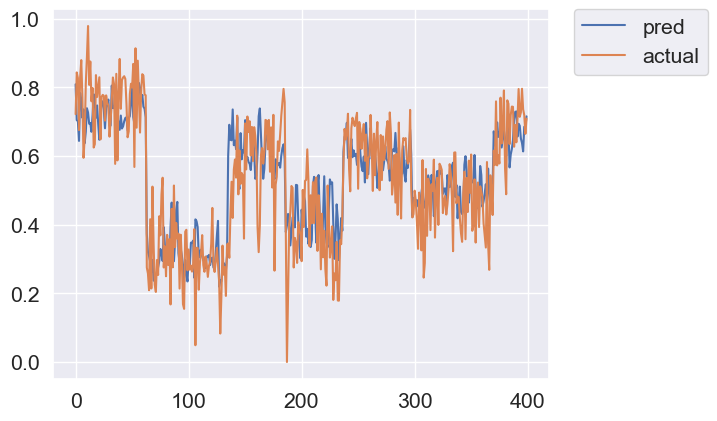

In [422]:
plt.plot(Y_hat_val[:,1], label = "pred")
plt.plot(X_val[:,1], label = "actual")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [423]:
# Select model with best loss on validation set!!
log_loss_val = np.array(log_loss_val)
mask = np.ravel(log_loss_val==min(log_loss_val))
label = list(itertools.compress(log_label_2, mask))[0]
print(label)

model = tf.keras.models.load_model(MODEL_PATH_2 + 'model_E_' + str(label) + '.h5')
Z_hat_train = model.predict(x=X_train)
Z_hat_val = model.predict(x=X_val)
Z_hat_test = model.predict(x=X_test)

Xs_Xs-Xs_Xs_h_a_0_run_4
38/38 [==============================] - 0s 1ms/step


In [424]:
# latent space dimension of the encoder
df_Z_train = pd.DataFrame(Z_hat_train)
df_Z_train

,0,1,2,3
0,6.001545,-0.602998,-3.189629,-3.139171
1,6.606514,-1.067560,-3.845462,-3.491352
2,6.674716,-1.175233,-3.922494,-3.638736
3,6.464076,-1.121882,-3.829435,-3.387807
4,6.479924,-1.266318,-3.909431,-3.295142
...,...,...,...,...
1595,6.606692,-1.526976,-4.013044,-3.304646
1596,6.256051,-0.937435,-3.684955,-2.930045
1597,6.105965,-0.663329,-3.613286,-2.541008
1598,5.877932,-0.642236,-3.462036,-2.380130


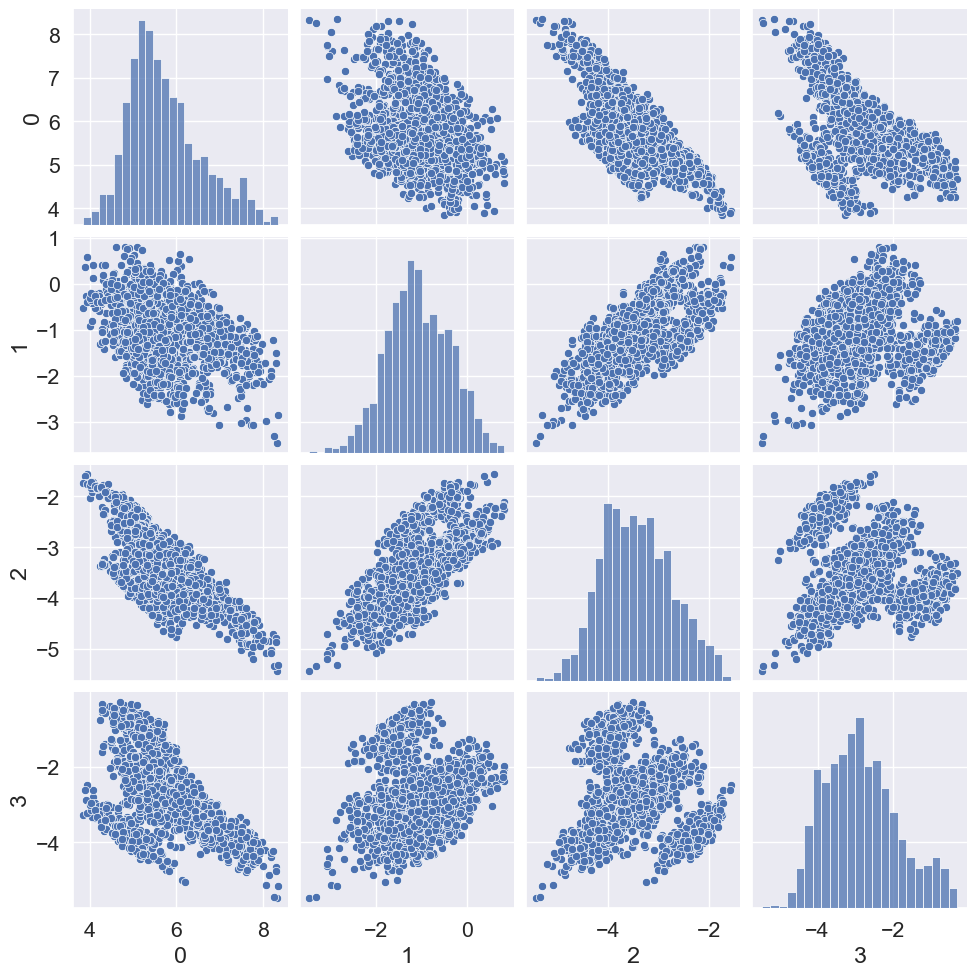

In [425]:
# Plot
sns.set(font_scale=1.4)
sns.pairplot(df_Z_train)

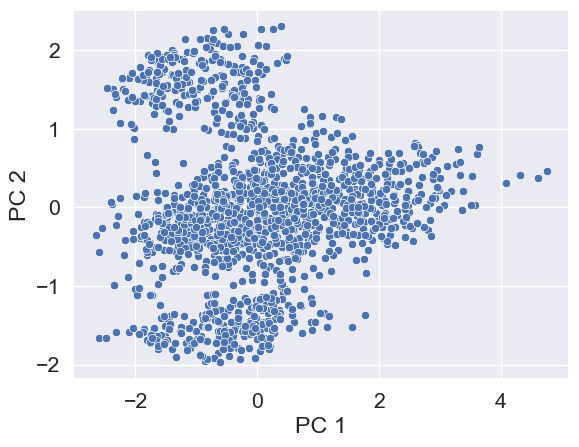

In [426]:
# apply PCA

# substract the mean
X = Z_hat_train - Z_hat_train.mean(axis = 0)

# pca with x dim
pca = PCA(n_components = 2)

# project the data on the new dimension
projected = pca.fit_transform(X)

df_projected = pd.DataFrame(projected[:, :2], columns=['PC 1', 'PC 2'])

#plot - what can you observe from the plot?
# plt.scatter(projected[:, 0], projected[:, 1], c=labels , edgecolor='none', alpha=0.5)
sns.scatterplot(data=df_projected, x='PC 1', y='PC 2')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# plt.colorbar()
plt.show()

df_projected_2 = pd.DataFrame(projected)

## reconstruction error and residuals

In [427]:
log_loss_val = np.array(log_loss_val)
def recon_res_err(data):
    """
    Takes best model from today and calculate mse between
    prediciton and and given data
    """
    
    mask = np.ravel(log_loss_val==min(log_loss_val))
    label = list(itertools.compress(log_label_2, mask))[0]
    print(label)

    model = tf.keras.models.load_model(MODEL_PATH_2 + 'model_AE_' + str(label) + '.h5')
    data_pred = model.predict(x=data)

    recon_errors = np.mean(np.power(data - data_pred, 2), axis=1)
    delta = data - data_pred
    return recon_errors, delta

In [428]:
recon_errors_train, delta_train = recon_res_err(X_train)
recon_errors_val, delta_val = recon_res_err(X_val)
recon_errors_test, delta_test = recon_res_err(X_test)

Xs_Xs-Xs_Xs_h_a_0_run_4
50/50 [==============================] - 0s 2ms/step
Xs_Xs-Xs_Xs_h_a_0_run_4
13/13 [==============================] - 0s 2ms/step
Xs_Xs-Xs_Xs_h_a_0_run_4
38/38 [==============================] - 0s 2ms/step


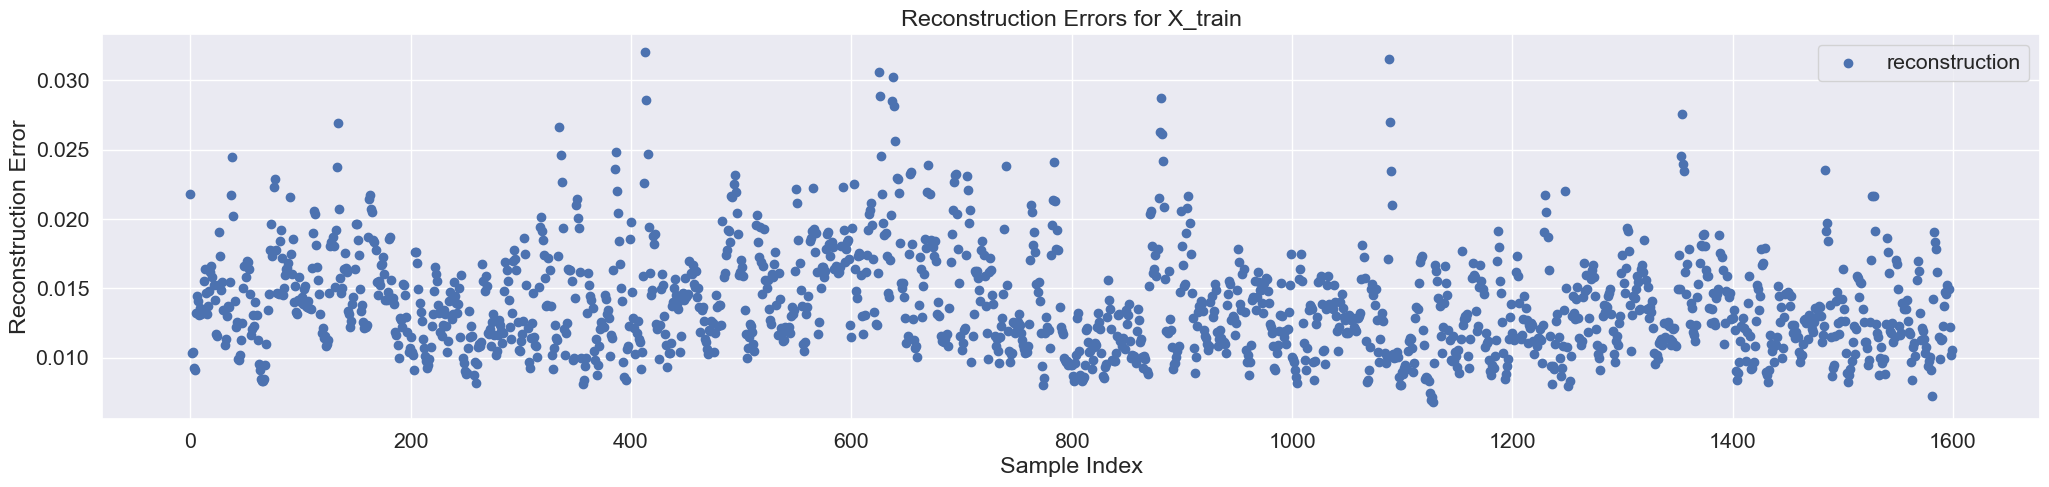

In [429]:
plt.figure(figsize = (25,5))
plt.scatter(np.arange(len(recon_errors_train)), recon_errors_train, label = 'reconstruction')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors for X_train')

plt.legend()
plt.show()


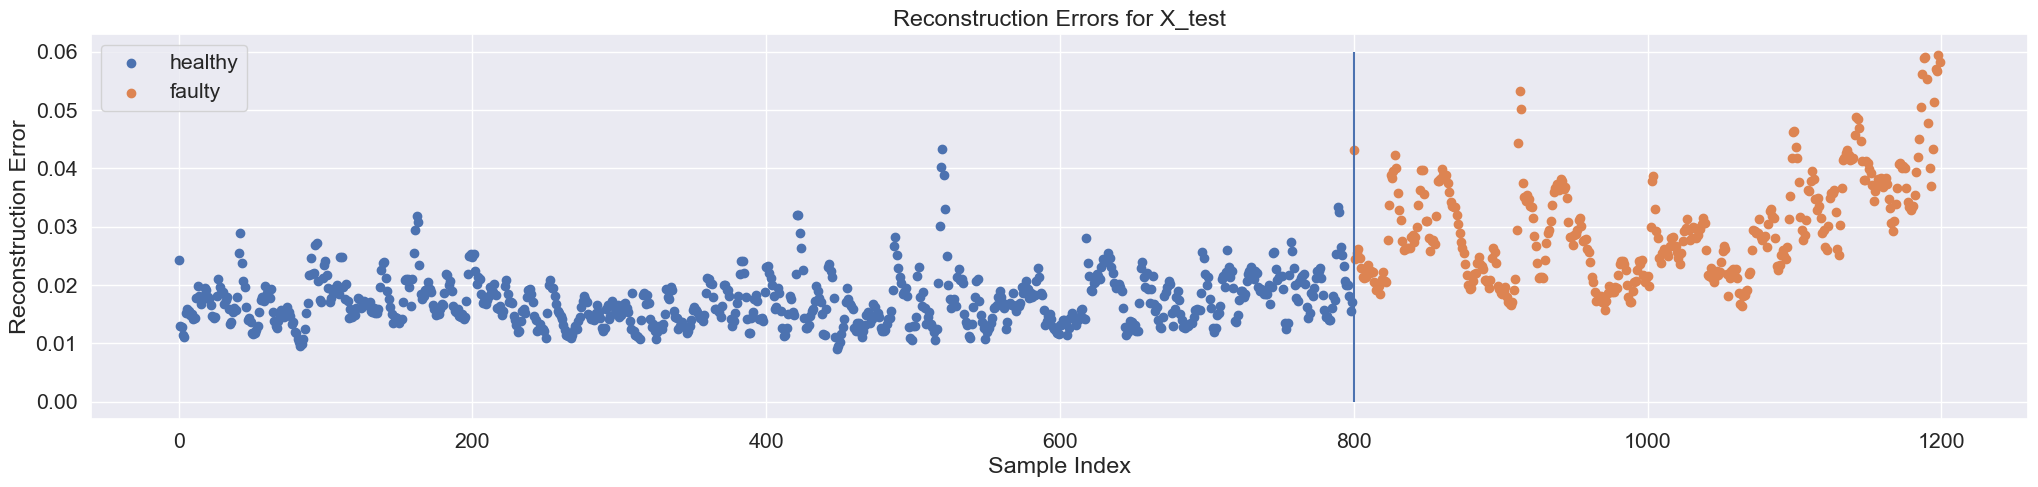

In [430]:
plt.figure(figsize = (25,5))

plt.scatter(np.arange(len(recon_errors_test[:max_norm_sample])), recon_errors_test[:max_norm_sample], label = 'healthy')
plt.scatter(np.arange(len(recon_errors_test[max_norm_sample:])) + max_norm_sample, recon_errors_test[max_norm_sample:], label = 'faulty')
plt.vlines(x=max_norm_sample, ymin = 0, ymax = 0.06)
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors for X_test')

plt.legend()
plt.show()

### residuals

In [431]:
print(delta_train)


[[-0.13227463 -0.16976386  0.02860904 ...  0.0311698  -0.00086567
  -0.01061106]
 [ 0.06316113  0.05553538  0.1268571  ...  0.05154151  0.03675964
   0.12342516]
 [ 0.11681926  0.10189658  0.09711844 ...  0.02759108  0.00337568
   0.04553121]
 ...
 [ 0.00039977  0.0961374  -0.09526384 ... -0.03498533 -0.00938848
   0.03184971]
 [-0.05997014  0.03523952 -0.01761645 ...  0.00249583  0.04010442
   0.0649257 ]
 [-0.0657106  -0.00252396 -0.10754254 ...  0.03893131  0.10735938
   0.03685802]]


## Define threshold for anomaly detection

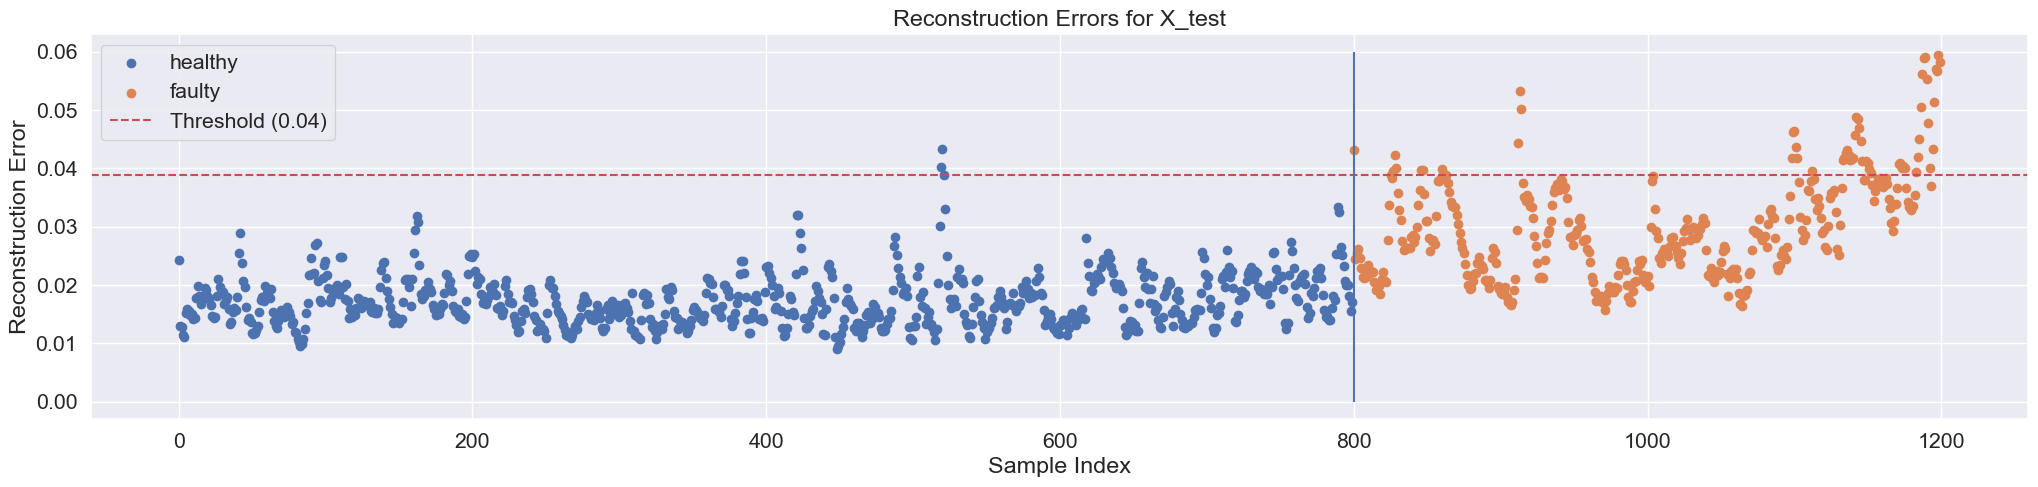

In [441]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for the reconstruction errors
recon_errors_df = pd.DataFrame(recon_errors_test, columns=['recon_error'])

# Label the dataset with 0 for healthy and 1 for anomaly
recon_errors_df['label'] = np.concatenate((np.zeros(max_norm_sample), np.ones(len(recon_errors_test) - max_norm_sample)))

# Create a threshold using the data (e.g., using the 95th percentile as an example)
threshold = np.percentile(recon_errors_df['recon_error'], 95)

# Plot the scatter plot with the threshold
plt.figure(figsize=(25, 5))
plt.scatter(np.arange(len(recon_errors_test[:max_norm_sample])), recon_errors_test[:max_norm_sample], label='healthy')
plt.scatter(np.arange(len(recon_errors_test[max_norm_sample:])) + max_norm_sample, recon_errors_test[max_norm_sample:], label='faulty')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.2f})')
plt.vlines(x=max_norm_sample, ymin=0, ymax=0.06)
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors for X_test')
plt.legend()
plt.show()


Confusion Matrix:
 [[798   2]
 [342  58]]


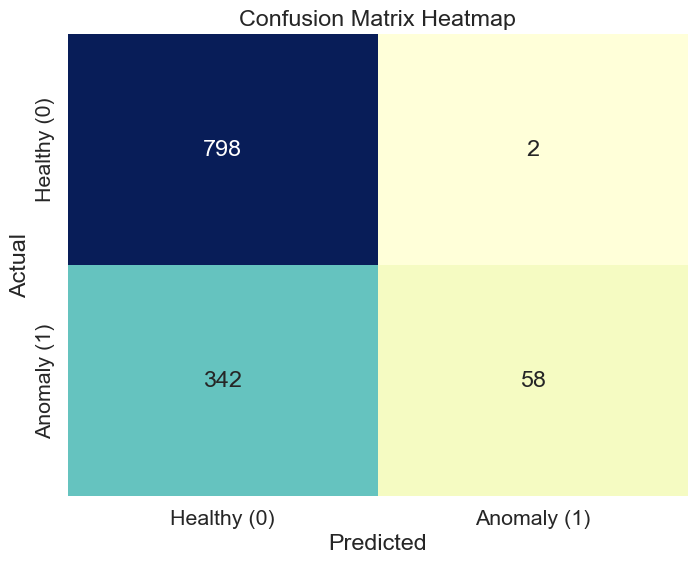

Accuracy: 0.71
Recall: 0.14
Precision: 0.97


In [442]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import seaborn as sns

# Create predictions based on the threshold
recon_errors_df['prediction'] = (recon_errors_df['recon_error'] > threshold).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(recon_errors_df['label'], recon_errors_df['prediction'])

# Calculate accuracy, recall, and precision
accuracy = accuracy_score(recon_errors_df['label'], recon_errors_df['prediction'])
recall = recall_score(recon_errors_df['label'], recon_errors_df['prediction'])
precision = precision_score(recon_errors_df['label'], recon_errors_df['prediction'])

# Print the results
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
            xticklabels=['Healthy (0)', 'Anomaly (1)'],
            yticklabels=['Healthy (0)', 'Anomaly (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")


## further


In [433]:
error_df = pd.DataFrame({'True_class': np.argmax(Y_test, axis=1),
                         'Reconstruction_error': recon_errors_test})


In [434]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_call

threshold_fixed = 0.3
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] = pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Print Accuracy, precision, and recall
print(" Accuracy: ", accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ", recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ", precision_score(error_df['True_class'], error_df['pred']))


ImportError: cannot import name 'precision_call' from 'sklearn.metrics' (S:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
mse = np.mean(np.power(Y_test - Y_hat_test, 2), axis=1)


In [ ]:
error_df = pd.DataFrame({'True_class': [1 if e > threshold_fixed else 0 for e in mse],
                         'MSE': mse})


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score


threshold_fixed = 0.3
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.MSE.values]
error_df['pred'] = pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Print Accuracy, precision, and recall
print(" Accuracy: ", accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ", recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ", precision_score(error_df['True_class'], error_df['pred']))
